# Import package

In [2]:
# Define train and val

import os
import shutil

class_name = ['MEL', 'NV', 'SCC', 'BCC', 'AK', 'VASC', 'DF', 'BKL']
count_imgs = [4522, 12875, 628, 3323, 867, 253, 239, 2624]
divide_val = []
for i in os.listdir("ISIC2019_train/Image"):
    class_path = os.path.join("ISIC2019_train/Image",i)
    
    tmp = 0
    val_num = round(count_imgs[class_name.index(i)] * 0.1)
    print(i,": ", count_imgs[class_name.index(i)], ": ", val_num)
    
    for j in os.listdir(class_path):
        tmp += 1
        old_img = os.path.join(class_path, j)
        new_img = "ISIC2019_testDR/" + i 
        
        shutil.move(old_img, new_img)

        if tmp == val_num:
            break
        
print(class_name)
print(count_imgs)

MEL :  4522 :  452
NV :  12875 :  1288
SCC :  628 :  63
BCC :  3323 :  332
AK :  867 :  87
VASC :  253 :  25
DF :  239 :  24
BKL :  2624 :  262
['MEL', 'NV', 'SCC', 'BCC', 'AK', 'VASC', 'DF', 'BKL']
[4522, 12875, 628, 3323, 867, 253, 239, 2624]


In [1]:
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import v2

from torch.utils.data import DataLoader
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import Adam
import loralib
from torch.nn import CrossEntropyLoss
from torch.utils.data import random_split, Sampler, WeightedRandomSampler
import matplotlib.pyplot as plt
from PIL import Image

import sys
from tqdm import tqdm
import time
import copy
from sklearn.metrics import roc_auc_score
from layers import Linear
import os

/home/user/miniconda3/envs/skin_cancer/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/user/miniconda3/envs/skin_cancer/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

In [2]:
torch.cuda.is_available()

True

# Set up Dataset

In [4]:
# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "ISIC2019_train/Image")
val_dir = os.path.join(current_directory, "ISIC2019_val")
print(train_dir)
print(val_dir)

/home/user/Dat/Vit/lora/ISIC2019_train/Image
/home/user/Dat/Vit/lora/ISIC2019_val


Check num worker

In [5]:
NUM_WORKERS = os.cpu_count()
NUM_WORKERS

12

## Create dataloader function
split image folder into train - 80% and test - 20%

In [6]:
def create_dataloaders(
    train_dir: str, 
    val_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    val_data = datasets.ImageFolder(val_dir, transform=transform)
    
    
#     train_size = int(0.8 * len(train_data))
#     test_size = len(train_data) - train_size
    
#     train_dataset, test_dataset = random_split(train_data, [train_size, test_size])    

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, val_dataloader, class_names

## Data preprocessing

## create transform

In [7]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


Set train_dir with ISIC2019 dataset

In [28]:
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, val_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE,
    num_workers=2
)

train_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f7a09b61a30>,
 ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'])

# Apply Mixup and Cutmix

In [26]:
# # cutmix = v2.CutMix(num_classes=NUM_CLASSES)
# mixup = v2.MixUp(num_classes=NUM_CLASSES)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

torch.Size([3, 224, 224]) tensor(5)


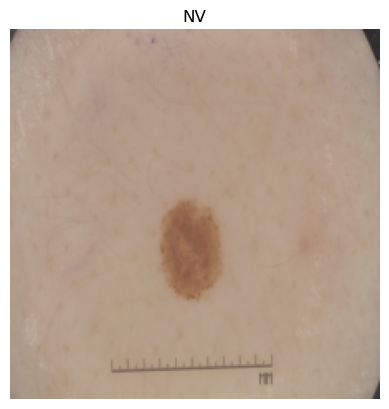

In [29]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# Create Model

## Use Swin Transformer pretrained

In [33]:
class SwinTransformer(nn.Module):
    def __init__(self, num_classes=8, dropout_rate=0.5):
        super(SwinTransformer, self).__init__()
        self.model = timm.create_model("swin_large_patch4_window7_224.ms_in22k", pretrained=True, num_classes=num_classes)

        # Dynamically obtain the feature dimension
        self.num_features = self.model.num_features
        
        # Additional layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):        
        x = self.model(x)
        x = x.view(x.size(0), -1)
        # # mat1 and mat2 shapes cannot be multiplied (16x9 and 768x512)
        x = F.relu(self.fc1(x))
        # x = F.relu(x)
        x = self.dropout(x)
        x = nn.functional.softmax(self.fc2(x), dim=1)
        
        return x
    
model = SwinTransformer(num_classes=8)

/home/user/miniconda3/envs/skin_cancer/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [156]:
model.swin_transformer.layers[0].blocks[0].norm1

LayerNorm((96,), eps=1e-05, elementwise_affine=True)

In [155]:
model.swin_transformer.layers[0]

SwinTransformerStage(
  (downsample): Identity()
  (blocks): Sequential(
    (0): SwinTransformerBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): WindowAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=96, out_features=96, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=384, out_features=96, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (drop_path2): Identity()
    )
    (1): SwinTransformerBlock(
      (norm1): LayerNorm((96,)

In [125]:
model.swin_transformer.norm

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [34]:
model.model.head

ClassifierHead(
  (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=Identity())
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=1536, out_features=8, bias=True)
  (flatten): Identity()
)

# Define Loss and Optimizer

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train & Val functions

Training function

In [17]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
    return train_loss / len(train_loader.dataset)


Validation function

In [28]:
def validate(model, val_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate AUC
    # Note: AUC calculation here is simplified and might need adjustments based on your label encoding
    # For multi-class, consider using a one-vs-rest approach

    
    auc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    return auc_score

Connect to gpu

In [36]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SwinTransformer(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768

Training

Epoch [1/10] Train Loss: 2.0887 Train Acc: 9.16% Val Loss: 2.0888 Val Acc: 12.37%
Epoch [2/10] Train Loss: 2.0890 Train Acc: 9.12% Val Loss: 2.0888 Val Acc: 12.30%
Epoch [3/10] Train Loss: 2.0890 Train Acc: 8.78% Val Loss: 2.0888 Val Acc: 12.33%
Epoch [4/10] Train Loss: 2.0888 Train Acc: 9.10% Val Loss: 2.0887 Val Acc: 12.65%
Epoch [5/10] Train Loss: 2.0889 Train Acc: 9.02% Val Loss: 2.0888 Val Acc: 12.51%
Epoch [6/10] Train Loss: 2.0888 Train Acc: 9.20% Val Loss: 2.0888 Val Acc: 12.35%
Epoch [7/10] Train Loss: 2.0888 Train Acc: 9.14% Val Loss: 2.0888 Val Acc: 12.39%
Epoch [8/10] Train Loss: 2.0889 Train Acc: 8.90% Val Loss: 2.0888 Val Acc: 12.43%
Epoch [9/10] Train Loss: 2.0889 Train Acc: 9.06% Val Loss: 2.0888 Val Acc: 12.39%
Epoch [10/10] Train Loss: 2.0889 Train Acc: 9.07% Val Loss: 2.0888 Val Acc: 12.55%


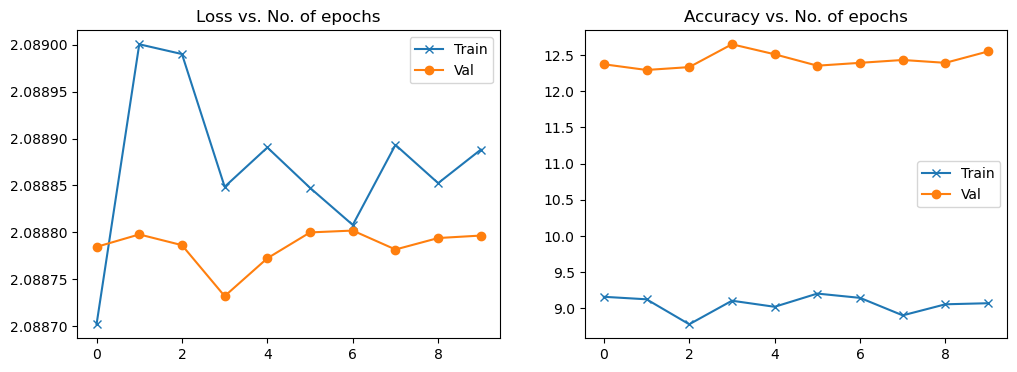

In [38]:
# Training loop
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    train_loss = running_loss / len(train_dataloader)
    train_acc = 100. * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_dataloader)
    val_acc = 100. * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

# Plotting Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-x', label='Train')
plt.plot(val_losses, '-o', label='Val')
plt.title('Loss vs. No. of epochs')
plt.legend()

# Plotting Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, '-x', label='Train')
plt.plot(val_accuracies, '-o', label='Val')
plt.title('Accuracy vs. No. of epochs')
plt.legend()
plt.show()

In [29]:
# training and validation loop
epochs = 5
for epoch in range(epochs):
    train_loss = train(model, criterion, optimizer, train_dataloader, device)
    auc_score = validate(model, test_dataloader, device)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, AUC: {auc_score:.4f}')

5
5


AxisError: axis 1 is out of bounds for array of dimension 1

In [31]:
test_labels = [0,1,2,3,4,5,6,7]
test_preds = [1,2,3,4,5,6,7,5]
tmp_auc = roc_auc_score(test_labels, test_preds, multi_class='ovr')

tmp_auc

AxisError: axis 1 is out of bounds for array of dimension 1